In [2]:
%%capture
%cd ..

In [3]:
import torch
from src.dataset import SifimDataset
from src.plot.timeseries_analysis import plot_with_thresholds

## Dataset

In [4]:
# dataset
noise = 0.1
tr_dataset = SifimDataset(start=0.0, end=0.6)
vl_dataset = SifimDataset(start=0.6, end=0.8, test=True, noise=noise)
ts_dataset = SifimDataset(start=0.8, end=1.0, test=True, noise=noise)
x_ts, y_ts = ts_dataset.x[:, :-1], ts_dataset.x[:, 1:]

## Model

In [5]:
model = torch.load('models/ESN.torch')

model

ESN(
  (reservoir): Reservoir()
)

## Plot

In [6]:
import pandas as pd
import os
columns_blacklist = ['timestamp', 'id', 'sub_id', 'contatore_di_installazione', 'contatore_di_misura',
                     'numero_seriale']
filename_name:str = 'dataset/raw/01-08-2023.csv'
datasets = {}
df_raw = pd.read_csv(f'{filename_name}')

# cleaning
df = df_raw.drop(columns=columns_blacklist)
df = df.columns
df = list(df)
df

['dpf_fase_1',
 'dpf_fase_2',
 'dpf_fase_3',
 'thd_corrente_fase_1',
 'thd_corrente_fase_2',
 'thd_corrente_fase_3',
 'thd_tensione_l_n_fase_1',
 'thd_tensione_l_n_fase_2',
 'thd_tensione_l_n_fase_3',
 'bilancio_energia_attiva_di_sistema',
 'componente_0_corrente_fase_1',
 'componente_0_corrente_fase_2',
 'componente_0_corrente_fase_3',
 'corrente_di_neutro',
 'corrente_di_sistema',
 'corrente_fase_1',
 'corrente_fase_2',
 'corrente_fase_3',
 'energia_apparente_importata_sistema',
 'energia_attiva_importata_di_sistema',
 'energia_attiva_importata_fase_1',
 'energia_attiva_importata_fase_2',
 'energia_attiva_importata_fase_3',
 'energia_reattiva_induttiva_importata_fase_1',
 'energia_reattiva_induttiva_importata_fase_2',
 'energia_reattiva_induttiva_importata_fase_3',
 'energia_reattiva_induttiva_importata_sistema',
 'fattore_di_potenza_di_sistema',
 'fattore_di_potenza_fase_1',
 'fattore_di_potenza_fase_2',
 'fattore_di_potenza_fase_3',
 'frequenza',
 'o10o_componente_corrente_fase_1',

In [23]:
import matplotlib.pyplot as plt
import numpy as np


def plot_with_thresholds(title, data, data_labels = [],plot_label = '', sigma = None, thresholds=[], fault_indicator=None, drift_indicator=None,
                         fault_detection_indicator=None):
    plt.figure(figsize=(10, 6))
    # Creazione del grafico
    for i, d in enumerate(data):
        plt.plot(d, label=f'{data_labels}', linestyle='-', color='r')

    # Aggiunta di threshold al grafico
    if sigma is not None:  
        mean = 0
        m2s = np.ones(len(data[0])) * sigma * (-2)
        p2s = np.ones(len(data[0])) * sigma * (+2)   
        plt.axhline(y=mean, color='g', linestyle='--', label='Fault Threshold')
        plt.fill_between(range(len(data[0])),p2s ,m2s,color='g', alpha=0.2)
    # Etichette per upper value e lower value
        plt.text(0, sigma * 2, '2\u03C3', color='g', fontsize=10, va='bottom', ha='left')
        plt.text(0, sigma * -2, '-2\u03C3', color='g', fontsize=10, va='top', ha='left')

    if fault_indicator is not None:
        plt.axvline(x=fault_indicator, color='g', linestyle='-', label='Fault')
    # if d:
    if drift_indicator is not None:
        plt.axvline(x=drift_indicator, color='b', linestyle='-', label='Drift')
    # if fd:
    if fault_detection_indicator is not None:
        plt.axvline(x=fault_detection_indicator, color='m', linestyle='--', label='Fault Detection')

    # Aggiunta di etichette e titolo
    plt.xlabel('Time')
    plt.ylabel(plot_label)
    plt.title(title)

    # Aggiunta di una legenda
    plt.legend(loc='upper left')

    # Visualizzazione del grafico
    plt.show()

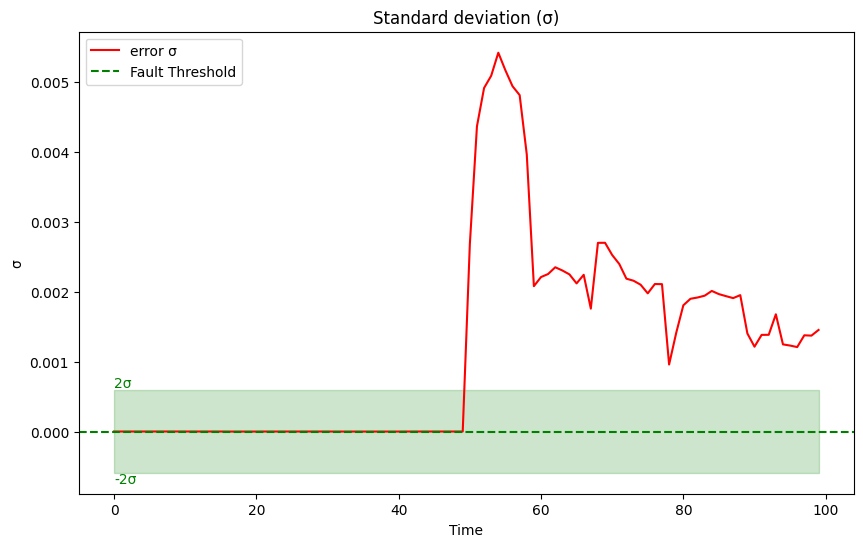

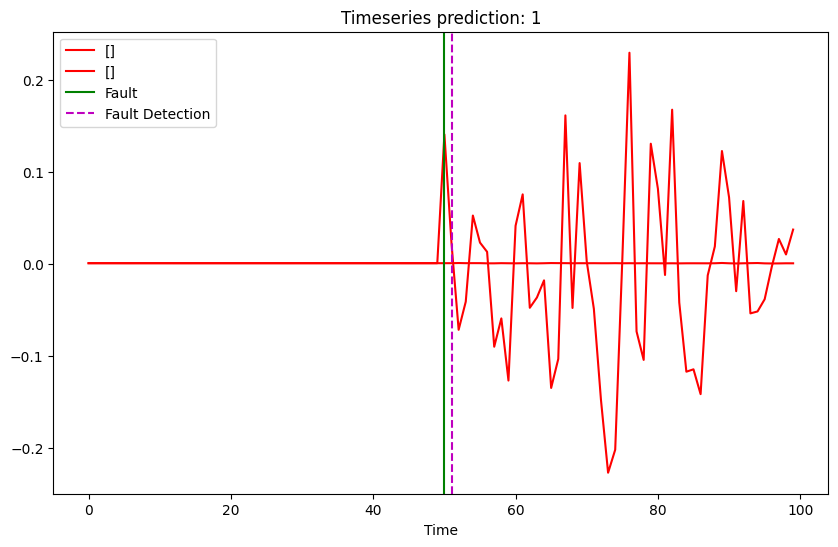

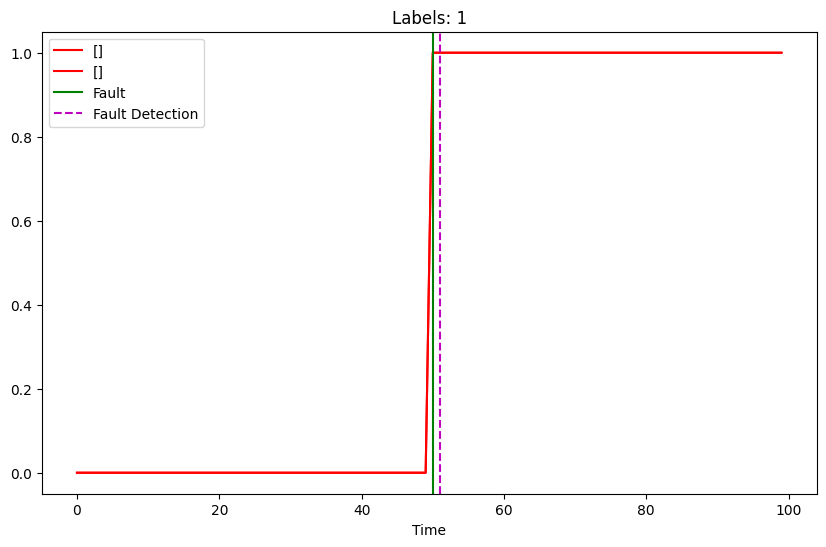

In [24]:
# test phase
ad_labels, ad_predictions, ad_std = model.predict(x_ts, y_ts)

# plot
window = 150
zoom = 50
start = 150 - zoom
end = 150 + zoom

i = 0
f = 1
# for f,c in enumerate(df):
std = ad_std[i, -window-zoom:-window+zoom]
labels_eff = ts_dataset.y[i,-window-zoom:-window+zoom]
labels_pred = ad_labels[i, -window-zoom:-window+zoom]
treshold_eff =  np.where(labels_eff == 1)[0][0]
treshold_pred =  np.where(labels_pred == 1)[0][0]
plot_with_thresholds(f'Standard deviation (\u03C3)', [std], sigma = model.sigma.item(), data_labels='error \u03C3', plot_label='\u03C3')  # standard deviation

y, p = ts_dataset.x[i, -window-zoom:-window+zoom, f], ad_predictions[i, -window-zoom:-window+zoom, f]
plot_with_thresholds(f'Timeseries prediction: {f}', [y, p], fault_indicator = treshold_eff, fault_detection_indicator = treshold_pred + 1)  # timeseries and prediction of lstm

plot_with_thresholds(f'Labels: {f}', [ts_dataset.y[i, -window-zoom:-window+zoom], ad_labels[i, -window-zoom:-window+zoom]],fault_indicator = treshold_eff, fault_detection_indicator = treshold_pred+1)  # labels

In [9]:
# # test phase
# ad_labels, ad_predictions, ad_std = model.predict(x_ts, y_ts)

# # plot
# window = 75
# i = 0
# f = 0

# std = ad_std[i, -window:]
# m2s = torch.ones_like(std) * model.sigma.item() * (-2)
# p2s = torch.ones_like(std) * model.sigma.item() * (+2)
# plot_with_thresholds('Standard deviation', [std, m2s, p2s])  # standard deviation

# y, p = ts_dataset.x[i, -window:, f], ad_predictions[i, -window:, f]
# plot_with_thresholds('Timeseries prediction', [y, p])  # timeseries and prediction of lstm

# plot_with_thresholds('Labels', [ts_dataset.y[i, -ad_labels.shape[1]:], ad_labels[i]])  # labels